In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
import re
import csv
import cPickle as pk


%matplotlib inline

In [2]:
pd.options.display.max_columns = 100

In [3]:
loc_master = pd.read_csv('LOCATION/location_master_data.csv')
loc_top = pd.read_csv('LOCATION/location_topology_data.csv')
track_maint = pd.read_csv('MAINT/Track Maintenance Possession.csv')
ref_loc = pd.read_csv('RH/reference_location_data.csv')
train_delays = pd.read_csv('RH/train_delays_old.csv')
train_track_sec = pd.read_csv('RH/train_track_sections.csv')
FLOC_desc = pd.read_csv('SAP/FLOC_descriptions.csv')
noti = pd.read_csv('SAP/Noti_20160401_to_20160630.csv')
raids = pd.read_excel('SAP/Raids Vs SAP 10-06-2016 V1.xlsx')
tsr = pd.read_excel('TSR/TSRData_20160401-20160630.xlsx')
train_meets = pd.read_csv('RH/train_meets.csv')
wo = pd.read_csv('SAP/WO_20160401_to_20160630.csv', skiprows=[0, 1])

/home/peterwen/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,4,5,49,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# TRAIN DELAYS

In [4]:
# Trains are delayed multiple times per trip
train_delays['TRAIN_ID'].unique().shape

(2274,)

In [5]:
train_delays

,DOWNTIME_ID,TRIP_LEG_TRAIN_ID,TRAIN_ID,CYCLE_LEG_ID,CYCLE_LEG_NAME,START_CYCLE_POINT_ID,START_CYCLE_POINT_NAME,START_LOCATION_ID,START_LOCATION_CODE,START_LOCATION_NAME,END_CYCLE_POINT_ID,END_CYCLE_POINT_NAME,END_LOCATION_ID,END_LOCATION_CODE,END_LOCATION_NAME,DOWNTIME_CYCLE_LEG_ID,DOWNTIME_CYCLE_LEG_NAME,DOWNTIME_TYPE_ID,DOWNTIME_TYPE_NAME,DOWNTIME_START_DATE,DOWNTIME_END_DATE,DOWNTIME_LOCATION_ID,DOWNTIME_LOCATION_CODE,DOWNTIME_LOCATION_NAME,DOWNTIME_COMMENTS,DOWNTIME_STATUS_ID,DOWNTIME_STATUS_NAME,DOWNTIME_STATUS_DATE,LEG_RUNTIME_HISTORY_ID,VARIANCE_MINUTES,MANUAL_DOWNTIME_FLAG,INITIAL_DOWNTIME_FLAG,DOWNTIME_CREATED_DATE,DOWNTIME_EVENT_ID,DOWNTIME_EVENT_ID.1,DOWNTIME_EVENT_DATE,DOWNTIME_EVENT_CAUSE_ID,DOWNTIME_EVENT_CAUSE_NAME,DOWNTIME_EVENT_CLASS_ID,DOWNTIME_EVENT_CLASS_CODE,DOWNTIME_EVENT_CLASS_NAME,DOWNTIME_EVENT_PAR_CLASS_ID,DOWNTIME_EVENT_PAR_CLASS_NAME,DOWNTIME_DEPARTMENT_ID,DOWNTIME_DEPARTMENT_CODE,DOWNTIME_DEPARTMENT_NAME,DOWNTIME_EVENT_LOCATION_ID,DOWNTIME_EVENT_LOC_TYPE_ID,DOWNTIME_EVENT_LOC_TYPE_NAME,DOWNTIME_EVENT_LOCATION_CODE,DOWNTIME_EVENT_LOCATION_NAME,DOWNTIME_EVENT_DESCRIPTION
0,80614,10430661,44401060,1390,Tabba Siding,94,Tabba South (to port),1000186,CA03:TAS:P11A,Tabba South 11A Pts,92,Tabba North (to port),1000181,CA03:TAN:P11A,Tabba North 11A Pts,1390,Tabba Siding,1,Stoppage,15/APR/2016 07:32:00,15/APR/2016 07:56:00,21006,TABBA,TABBA SIDING,NaN,2,Completed,15/APR/2016 08:46:30,156,NaN,N,N,15/APR/2016 07:57:51,66247,66247,15/APR/2016 07:09:00,203,(TOA) Scheduled Track Occupation Authority,1,SPD,Scheduled Process Downtime,1,Scheduled,4,TS,Track and Signals,21003,12,TRACK SECTION,MOOKA - WALLA,MOOKA - WALLA,Scheduled LPA on the ET from Bing South - 67
1,80955,10439889,44439060,1423,Gillam - Tabba,34,Gillam North (to port),1000198,CA03:GMN:P11A,Gillam North 11A Pts,94,Tabba South (to port),1000187,CA03:TAS:P11B,Tabba South 11B Pts,1423,Gillam - Tabba,1,Stoppage,17/APR/2016 14:27:00,17/APR/2016 18:01:00,21007,TABBA - GILLAM,TABBA - GILLAM,NaN,2,Completed,17/APR/2016 18:06:26,155,NaN,N,N,17/APR/2016 18:03:51,66458,66458,17/APR/2016 10:33:00,203,(TOA) Scheduled Track Occupation Authority,1,SPD,Scheduled Process Downtime,1,Scheduled,4,TS,Track and Signals,21006,12,TRACK SECTION,TABBA,TABBA SIDING,TOA 67KM-TABBA
2,81016,10441968,44465263,1438,Spring - Garden,89,Spring South (to mine),1000318,CA05:SGS:P11A,Spring South 11A Pts,25,Garden North (to mine),1000327,CA06:GNN:P11B,Garden North 11B Pts,1438,Spring - Garden,1,Stoppage,18/APR/2016 01:39:00,18/APR/2016 02:51:00,21019,SPRING - GARDEN,SPRING - GARDEN,NaN,2,Completed,18/APR/2016 03:08:11,64,NaN,N,N,18/APR/2016 02:52:54,66509,66509,17/APR/2016 19:30:00,37,ECPB Penalty,4,UED,Unscheduled Equipment Downtime,2,Unscheduled,2,LOCO,Locomotives,1000414,12,TRACK SECTION,CHICHESTER - COWRA,CHICHESTER - COWRA,ECPB penalty train walk require C245.5 ECPB p...
3,81042,10443391,44463240,1663,JBJ South - JBJ North,183,JBJ South (to port),1000717,CA11:JJSC:P57,Jimblebar Jtn 57 Pts,50,JBJ North (to port),1000388,CA11:JJN:P51,Jimblebar Jtn 51 Pts,1663,JBJ South - JBJ North,1,Stoppage,18/APR/2016 08:42:00,18/APR/2016 09:35:00,21109,JIMBLEBAR JUNCTION,JIMBLEBAR JUNCTION,NaN,2,Completed,18/APR/2016 11:57:49,254,NaN,N,Y,18/APR/2016 09:36:51,66570,66570,18/APR/2016 11:56:00,92,Train Meet,1,SPD,Scheduled Process Downtime,1,Scheduled,3,ROP,Railroad Operations,21109,12,TRACK SECTION,JIMBLEBAR JUNCTION,JIMBLEBAR JUNCTION,Meet Train M06444
4,81073,10444072,44467086,10128,OB18 North - Jimblebar Hub,10108,OB18 North (to mine),1000727,CA16:OB18N:P61A,OB 18 Pts 61A,10112,Jimblebar Hub (to mine),1000739,CA16:JHN:P66,Jimblebar Hub North 66 Pts,10128,OB18 North - Jimblebar Hub,1,Stoppage,18/APR/2016 13:27:00,18/APR/2016 15:56:00,1000828,OB18 NORTH - JIMBLEBAR HUB,OB18 NORTH - JIMBLEBAR HUB,NaN,2,Completed,18/APR/2016 17:27:22,140,NaN,N,Y,18/APR/2016 15:57:51,66583,66583,18/APR/2016 17:26:00,28,Queuing - Mines,1,SPD,Scheduled Process Downtime,1,Scheduled,7,MINE,Mines,1000828,12,TRACK SECTION,OB

### FUNCTIONS

In [6]:
def convert_dt(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col])
        
def countp(df, col, size=(20, 10), rotate=True):
    plt.figure(figsize=size)
    sns.countplot(df[col])
    if rotate:
        plt.xticks(rotation=90)
        
def delay_info(df, col, cat):
    delay_length = df[df[col] == cat]['LENGTH_OF_DELAY']
    print 'Mean delay length for {}: {}'.format(cat, delay_length.mean())
    print 'Median delay length for {}: {}'.format(cat, delay_length.median())
    print 'Max delay length for {}: {}'.format(cat, delay_length.max())

def bucket_causes(df, col):
    df['DELAY_CAUSES_BUCKETED'] = df['DOWNTIME_EVENT_CAUSE_NAME'].apply(lambda x: delay_mapping[x.split()[0]])

### GENERAL INFO

In [7]:
train_delays.shape

(7868, 52)



### START LOCATION ID

In [8]:
Counter(train_delays['START_LOCATION_ID']).most_common(5)

[(1000341, 474),
 (1000150, 288),
 (1000327, 249),
 (1000160, 245),
 (1000374, 224)]

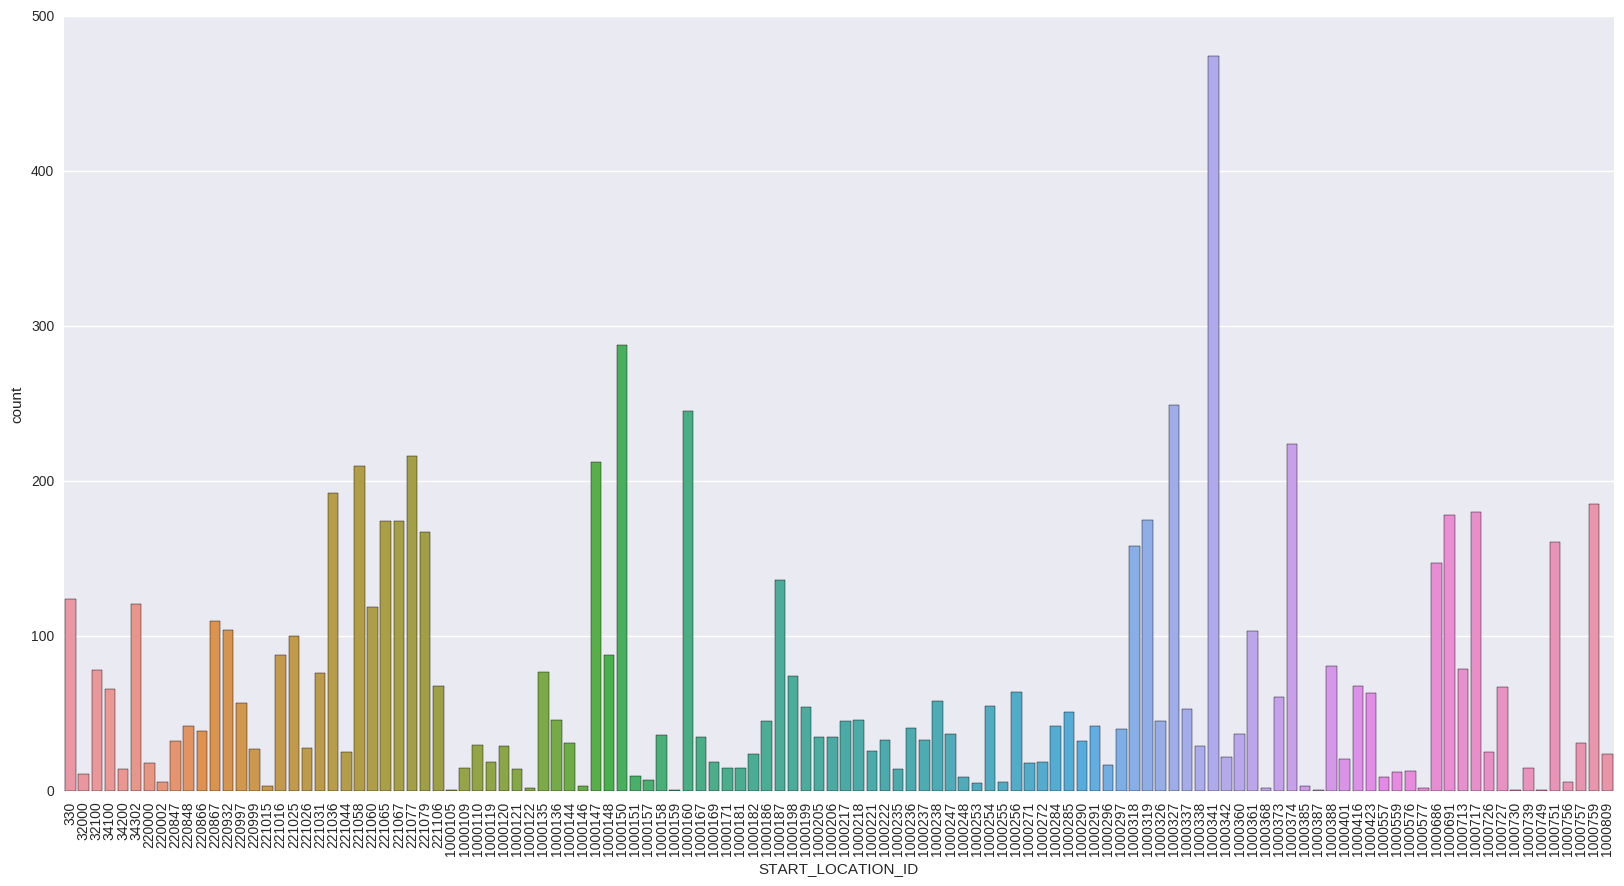

In [9]:
countp(train_delays, 'START_LOCATION_ID')

In [10]:
train_delays[train_delays['START_LOCATION_ID'] == train_delays['END_LOCATION_ID']]

,DOWNTIME_ID,TRIP_LEG_TRAIN_ID,TRAIN_ID,CYCLE_LEG_ID,CYCLE_LEG_NAME,START_CYCLE_POINT_ID,START_CYCLE_POINT_NAME,START_LOCATION_ID,START_LOCATION_CODE,START_LOCATION_NAME,END_CYCLE_POINT_ID,END_CYCLE_POINT_NAME,END_LOCATION_ID,END_LOCATION_CODE,END_LOCATION_NAME,DOWNTIME_CYCLE_LEG_ID,DOWNTIME_CYCLE_LEG_NAME,DOWNTIME_TYPE_ID,DOWNTIME_TYPE_NAME,DOWNTIME_START_DATE,DOWNTIME_END_DATE,DOWNTIME_LOCATION_ID,DOWNTIME_LOCATION_CODE,DOWNTIME_LOCATION_NAME,DOWNTIME_COMMENTS,DOWNTIME_STATUS_ID,DOWNTIME_STATUS_NAME,DOWNTIME_STATUS_DATE,LEG_RUNTIME_HISTORY_ID,VARIANCE_MINUTES,MANUAL_DOWNTIME_FLAG,INITIAL_DOWNTIME_FLAG,DOWNTIME_CREATED_DATE,DOWNTIME_EVENT_ID,DOWNTIME_EVENT_ID.1,DOWNTIME_EVENT_DATE,DOWNTIME_EVENT_CAUSE_ID,DOWNTIME_EVENT_CAUSE_NAME,DOWNTIME_EVENT_CLASS_ID,DOWNTIME_EVENT_CLASS_CODE,DOWNTIME_EVENT_CLASS_NAME,DOWNTIME_EVENT_PAR_CLASS_ID,DOWNTIME_EVENT_PAR_CLASS_NAME,DOWNTIME_DEPARTMENT_ID,DOWNTIME_DEPARTMENT_CODE,DOWNTIME_DEPARTMENT_NAME,DOWNTIME_EVENT_LOCATION_ID,DOWNTIME_EVENT_LOC_TYPE_ID,DOWNTIME_EVENT_LOC_TYPE_NAME,DOWNTIME_EVENT_LOCATION_CODE,DOWNTIME_EVENT_LOCATION_NAME,DOWNTIME_EVENT_DESCRIPTION
100,80630,10430213,44414451,1805,Load 2,10028,Rake Start Load 2,32100,YD-LD-LD2,Yandi 2 Loadout,10029,Rake End Load 2,32100,YD-LD-LD2,Yandi 2 Loadout,1805,Load 2,2,Variance,15/APR/2016 07:18:00,15/APR/2016 11:00:00,32100,YD-LD-LD2,Yandi 2 Loadout,NaN,2,Completed,15/APR/2016 11:50:57,278,221.83,N,Y,15/APR/2016 11:06:51,66265,66265,15/APR/2016 11:49:00,15,Unscheduled Process - Mines,2,UPD,Unscheduled Process Downtime,2,Unscheduled,7,MINE,Mines,32100,6,Loader,YD-LD-LD2,Yandi 2 Loadout,Unscheduled Process - Mines
103,80999,10440849,44454882,1362,Load 1,76,Rake Load Start,34302,MW-P9-LOUT-TRN1,Newman Hub New Loadout,75,Rake Load End,34302,MW-P9-LOUT-TRN1,Newman Hub New Loadout,1362,Load 1,2,Variance,17/APR/2016 22:04:00,17/APR/2016 23:25:00,34302,MW-P9-LOUT-TRN1,Newman Hub New Loadout,NaN,2,Completed,17/APR/2016 23:54:27,1,81.62,N,Y,17/APR/2016 23:35:52,66526,66526,17/APR/2016 23:53:00,15,Unscheduled Process - Mines,2,UPD,Unscheduled Process Downtime,2,Unscheduled,7,MINE,Mines,34302,6,Loader,MW-P9-LOUT-TRN1,Newman Hub New Loadout,Unscheduled Process - Mines
141,81271,10448594,44489904,1362,Load 1,76,Rake Load Start,330,AC-LD-LD1,MAC Loadout,75,Rake Load End,330,AC-LD-LD1,MAC Loadout,1362,Load 1,2,Variance,19/APR/2016 21:27:00,19/APR/2016 23:28:00,330,AC-LD-LD1,MAC Loadout,NaN,2,Completed,19/APR/2016 23:51:23,197,120.61,N,Y,19/APR/2016 23:34:52,66690,66690,19/APR/2016 23:50:00,15,Unscheduled Process - Mines,2,UPD,Unscheduled Process Downtime,2,Unscheduled,7,MINE,Mines,330,6,Loader,AC-LD-LD1,MAC Loadout,Unscheduled Process - Mines
208,81112,10444588,44466859,1362,Load 1,76,Rake Load Start,34302,MW-P9-LOUT-TRN1,Newman Hub New Loadout,75,Rake Load End,34302,MW-P9-LOUT-TRN1,Newman Hub New Loadout,1362,Load 1,2,Variance,18/APR/2016 19:20:00,18/APR/2016 20:59:00,34302,MW-P9-LOUT-TRN1,Newman Hub New Loadout,NaN,2,Completed,18/APR/2016 21:14:32,1,99.70,N,Y,18/APR/2016 21:05:52,66594,66594,18/APR/2016 21:14:00,15,Unscheduled Process - Mines,2,UPD,Unscheduled Process Downtime,2,Unscheduled,7,MINE,Mines,34302,6,Loader,MW-P9-LOUT-TRN1,Newman Hub New Loadout,Unscheduled Process - Mines
226,81210,10448128,44482992,1805,Load 2,10028,Rake Start Load 2,32100,YD-LD-LD2,Yandi 2 Loadout,10029,Rake End Load 2,32100,YD-LD-LD2,Yandi 2 Loadout,1805,Load 2,2,Variance,19/APR/2016 13:57:00,19/APR/2016 15:01:00,32100,YD-LD-LD2,Yandi 2 Loadout,NaN,2,Completed,19/APR/2016 17:16:13,278,63.83,N,Y,19/APR/2016 15:12:52,66670,66670,19/APR/2016 17:14:00,28,Queuing - Mines,1,SPD,Scheduled Process Downtime,1,Scheduled,7,MINE,Mines,32100,6,Loader,YD-LD-LD2,Yandi 2 Loadout,Queuing - Mines
253,81000,10440500,44458743,1362,Load 1,76,Rake Load Start,330,AC-LD-LD1,MAC Loadout,75,Rake Load End,330,AC-LD-LD1,MAC Loadout,1362,Load 1,2,Variance,17/APR/2016 21:15:00,17/APR/2016 23:32:00,330,AC-LD-LD1,MAC Loadout,NaN,2,Completed,17/APR/2016 23:45:41,197,137.19,N,Y,17/APR/2016 23:37:52,66

### DOWNTIME CYCLE LEG ID

In [11]:
Counter(train_delays['DOWNTIME_CYCLE_LEG_ID']).most_common(10)

[(1364, 502),
 (1372, 489),
 (1367, 373),
 (1378, 289),
 (1400, 257),
 (1365, 241),
 (1383, 212),
 (1411, 210),
 (1362, 188),
 (1377, 188)]

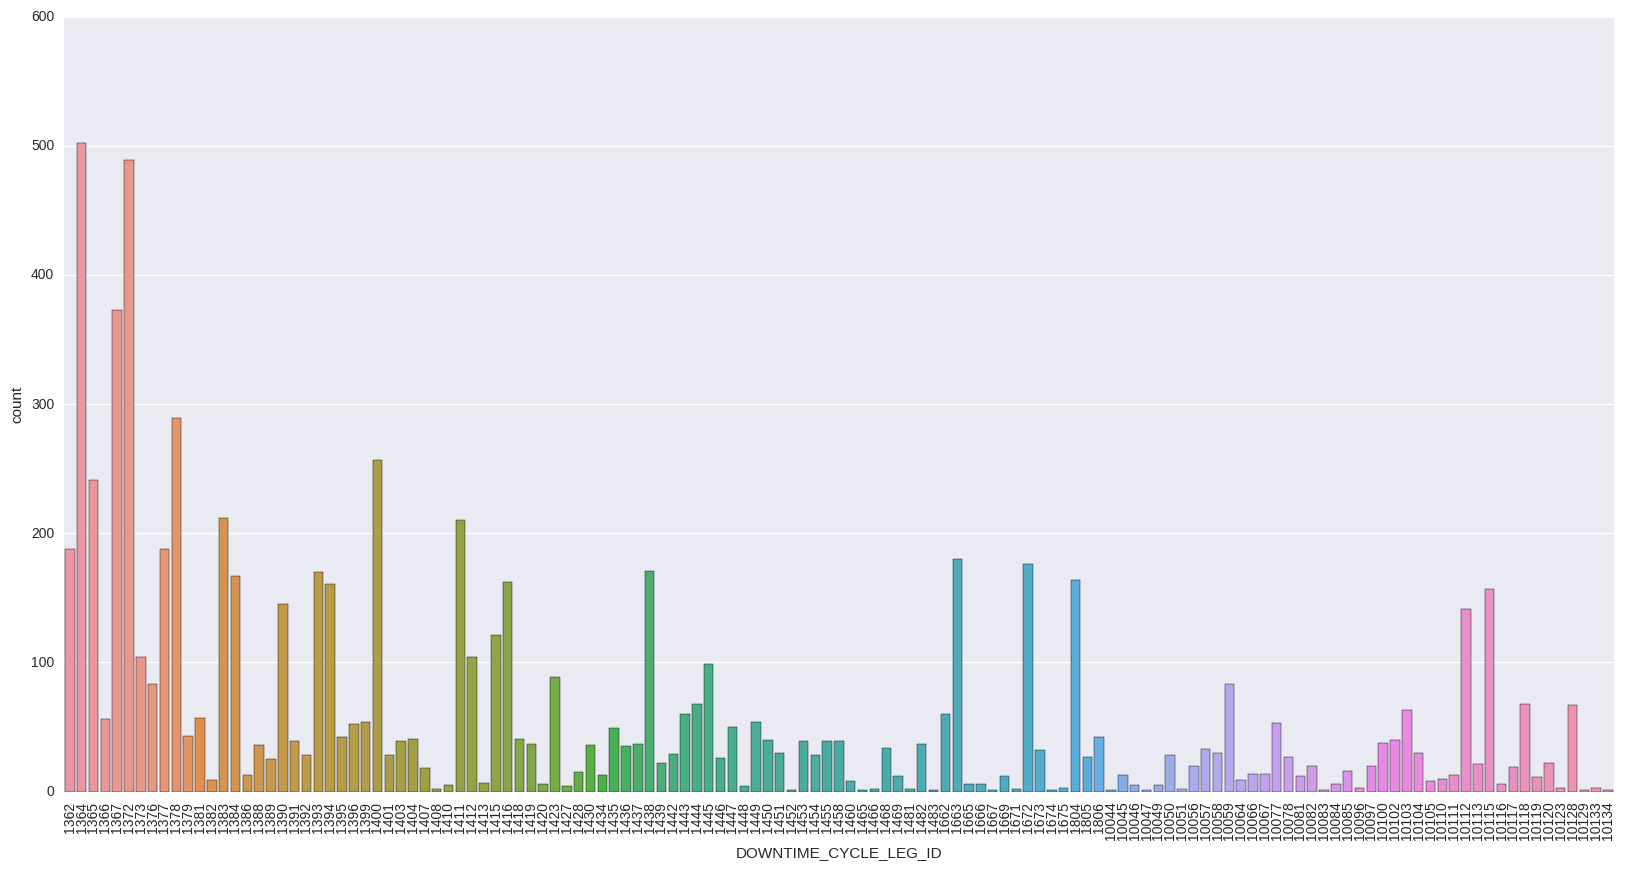

In [12]:
countp(train_delays, 'DOWNTIME_CYCLE_LEG_ID')

### LENGTH OF DELAY

In [13]:
convert_dt(train_delays, ['DOWNTIME_START_DATE', 'DOWNTIME_END_DATE'])

In [14]:
train_delays

,DOWNTIME_ID,TRIP_LEG_TRAIN_ID,TRAIN_ID,CYCLE_LEG_ID,CYCLE_LEG_NAME,START_CYCLE_POINT_ID,START_CYCLE_POINT_NAME,START_LOCATION_ID,START_LOCATION_CODE,START_LOCATION_NAME,END_CYCLE_POINT_ID,END_CYCLE_POINT_NAME,END_LOCATION_ID,END_LOCATION_CODE,END_LOCATION_NAME,DOWNTIME_CYCLE_LEG_ID,DOWNTIME_CYCLE_LEG_NAME,DOWNTIME_TYPE_ID,DOWNTIME_TYPE_NAME,DOWNTIME_START_DATE,DOWNTIME_END_DATE,DOWNTIME_LOCATION_ID,DOWNTIME_LOCATION_CODE,DOWNTIME_LOCATION_NAME,DOWNTIME_COMMENTS,DOWNTIME_STATUS_ID,DOWNTIME_STATUS_NAME,DOWNTIME_STATUS_DATE,LEG_RUNTIME_HISTORY_ID,VARIANCE_MINUTES,MANUAL_DOWNTIME_FLAG,INITIAL_DOWNTIME_FLAG,DOWNTIME_CREATED_DATE,DOWNTIME_EVENT_ID,DOWNTIME_EVENT_ID.1,DOWNTIME_EVENT_DATE,DOWNTIME_EVENT_CAUSE_ID,DOWNTIME_EVENT_CAUSE_NAME,DOWNTIME_EVENT_CLASS_ID,DOWNTIME_EVENT_CLASS_CODE,DOWNTIME_EVENT_CLASS_NAME,DOWNTIME_EVENT_PAR_CLASS_ID,DOWNTIME_EVENT_PAR_CLASS_NAME,DOWNTIME_DEPARTMENT_ID,DOWNTIME_DEPARTMENT_CODE,DOWNTIME_DEPARTMENT_NAME,DOWNTIME_EVENT_LOCATION_ID,DOWNTIME_EVENT_LOC_TYPE_ID,DOWNTIME_EVENT_LOC_TYPE_NAME,DOWNTIME_EVENT_LOCATION_CODE,DOWNTIME_EVENT_LOCATION_NAME,DOWNTIME_EVENT_DESCRIPTION
0,80614,10430661,44401060,1390,Tabba Siding,94,Tabba South (to port),1000186,CA03:TAS:P11A,Tabba South 11A Pts,92,Tabba North (to port),1000181,CA03:TAN:P11A,Tabba North 11A Pts,1390,Tabba Siding,1,Stoppage,2016-04-15 07:32:00,2016-04-15 07:56:00,21006,TABBA,TABBA SIDING,NaN,2,Completed,15/APR/2016 08:46:30,156,NaN,N,N,15/APR/2016 07:57:51,66247,66247,15/APR/2016 07:09:00,203,(TOA) Scheduled Track Occupation Authority,1,SPD,Scheduled Process Downtime,1,Scheduled,4,TS,Track and Signals,21003,12,TRACK SECTION,MOOKA - WALLA,MOOKA - WALLA,Scheduled LPA on the ET from Bing South - 67
1,80955,10439889,44439060,1423,Gillam - Tabba,34,Gillam North (to port),1000198,CA03:GMN:P11A,Gillam North 11A Pts,94,Tabba South (to port),1000187,CA03:TAS:P11B,Tabba South 11B Pts,1423,Gillam - Tabba,1,Stoppage,2016-04-17 14:27:00,2016-04-17 18:01:00,21007,TABBA - GILLAM,TABBA - GILLAM,NaN,2,Completed,17/APR/2016 18:06:26,155,NaN,N,N,17/APR/2016 18:03:51,66458,66458,17/APR/2016 10:33:00,203,(TOA) Scheduled Track Occupation Authority,1,SPD,Scheduled Process Downtime,1,Scheduled,4,TS,Track and Signals,21006,12,TRACK SECTION,TABBA,TABBA SIDING,TOA 67KM-TABBA
2,81016,10441968,44465263,1438,Spring - Garden,89,Spring South (to mine),1000318,CA05:SGS:P11A,Spring South 11A Pts,25,Garden North (to mine),1000327,CA06:GNN:P11B,Garden North 11B Pts,1438,Spring - Garden,1,Stoppage,2016-04-18 01:39:00,2016-04-18 02:51:00,21019,SPRING - GARDEN,SPRING - GARDEN,NaN,2,Completed,18/APR/2016 03:08:11,64,NaN,N,N,18/APR/2016 02:52:54,66509,66509,17/APR/2016 19:30:00,37,ECPB Penalty,4,UED,Unscheduled Equipment Downtime,2,Unscheduled,2,LOCO,Locomotives,1000414,12,TRACK SECTION,CHICHESTER - COWRA,CHICHESTER - COWRA,ECPB penalty train walk require C245.5 ECPB p...
3,81042,10443391,44463240,1663,JBJ South - JBJ North,183,JBJ South (to port),1000717,CA11:JJSC:P57,Jimblebar Jtn 57 Pts,50,JBJ North (to port),1000388,CA11:JJN:P51,Jimblebar Jtn 51 Pts,1663,JBJ South - JBJ North,1,Stoppage,2016-04-18 08:42:00,2016-04-18 09:35:00,21109,JIMBLEBAR JUNCTION,JIMBLEBAR JUNCTION,NaN,2,Completed,18/APR/2016 11:57:49,254,NaN,N,Y,18/APR/2016 09:36:51,66570,66570,18/APR/2016 11:56:00,92,Train Meet,1,SPD,Scheduled Process Downtime,1,Scheduled,3,ROP,Railroad Operations,21109,12,TRACK SECTION,JIMBLEBAR JUNCTION,JIMBLEBAR JUNCTION,Meet Train M06444
4,81073,10444072,44467086,10128,OB18 North - Jimblebar Hub,10108,OB18 North (to mine),1000727,CA16:OB18N:P61A,OB 18 Pts 61A,10112,Jimblebar Hub (to mine),1000739,CA16:JHN:P66,Jimblebar Hub North 66 Pts,10128,OB18 North - Jimblebar Hub,1,Stoppage,2016-04-18 13:27:00,2016-04-18 15:56:00,1000828,OB18 NORTH - JIMBLEBAR HUB,OB18 NORTH - JIMBLEBAR HUB,NaN,2,Completed,18/APR/2016 17:27:22,140,NaN,N,Y,18/APR/2016 15:57:51,66583,66583,18/APR/2016 17:26:00,28,Queuing - Mines,1,SPD,Scheduled Process Downtime,1,Scheduled,7,MINE,Mines,1000828,12,TRACK SECTION,OB18 NORTH -

In [15]:
train_delays['LENGTH_OF_DELAY'] = pd.to_datetime(train_delays['DOWNTIME_END_DATE'] - train_delays['DOWNTIME_START_DATE'])
train_delays['LENGTH_OF_DELAY'] = train_delays['LENGTH_OF_DELAY'].apply(lambda x: x.hour * 60 + x.minute)

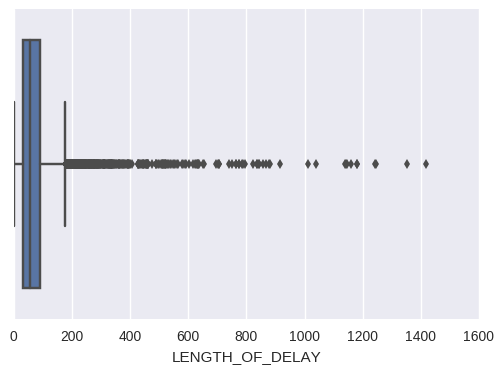

In [16]:
sns.boxplot(train_delays['LENGTH_OF_DELAY'])

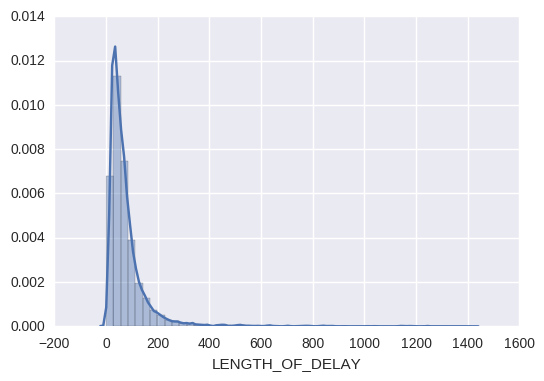

In [17]:
sns.distplot(train_delays['LENGTH_OF_DELAY'])

In [18]:
print 'The mean delays is {:.2f} minutes.'.format(train_delays['LENGTH_OF_DELAY'].mean())
print 'The median delays is {:.2f} minutes.'.format(train_delays['LENGTH_OF_DELAY'].median())
print 'The max delays is {:.2f} minutes.'.format(train_delays['LENGTH_OF_DELAY'].max())

The mean delays is 78.07 minutes.
The median delays is 55.00 minutes.
The max delays is 1418.00 minutes.


### EXTRACT DATE INFO

In [19]:
train_delays['DOWNTIME_START_DAY'] = train_delays['DOWNTIME_START_DATE'].apply(lambda x: x.day)

### LOOK AT OUTLIERS

In [20]:
iqr = np.percentile(train_delays['LENGTH_OF_DELAY'], 75) - np.percentile(train_delays['LENGTH_OF_DELAY'], 25)

In [21]:
outlier_threshold = np.percentile(train_delays['LENGTH_OF_DELAY'], 75) + 1.5 * iqr

In [22]:
outlier_delays = train_delays[train_delays['LENGTH_OF_DELAY'] > outlier_threshold]

In [23]:
outlier_delays.shape

(533, 54)

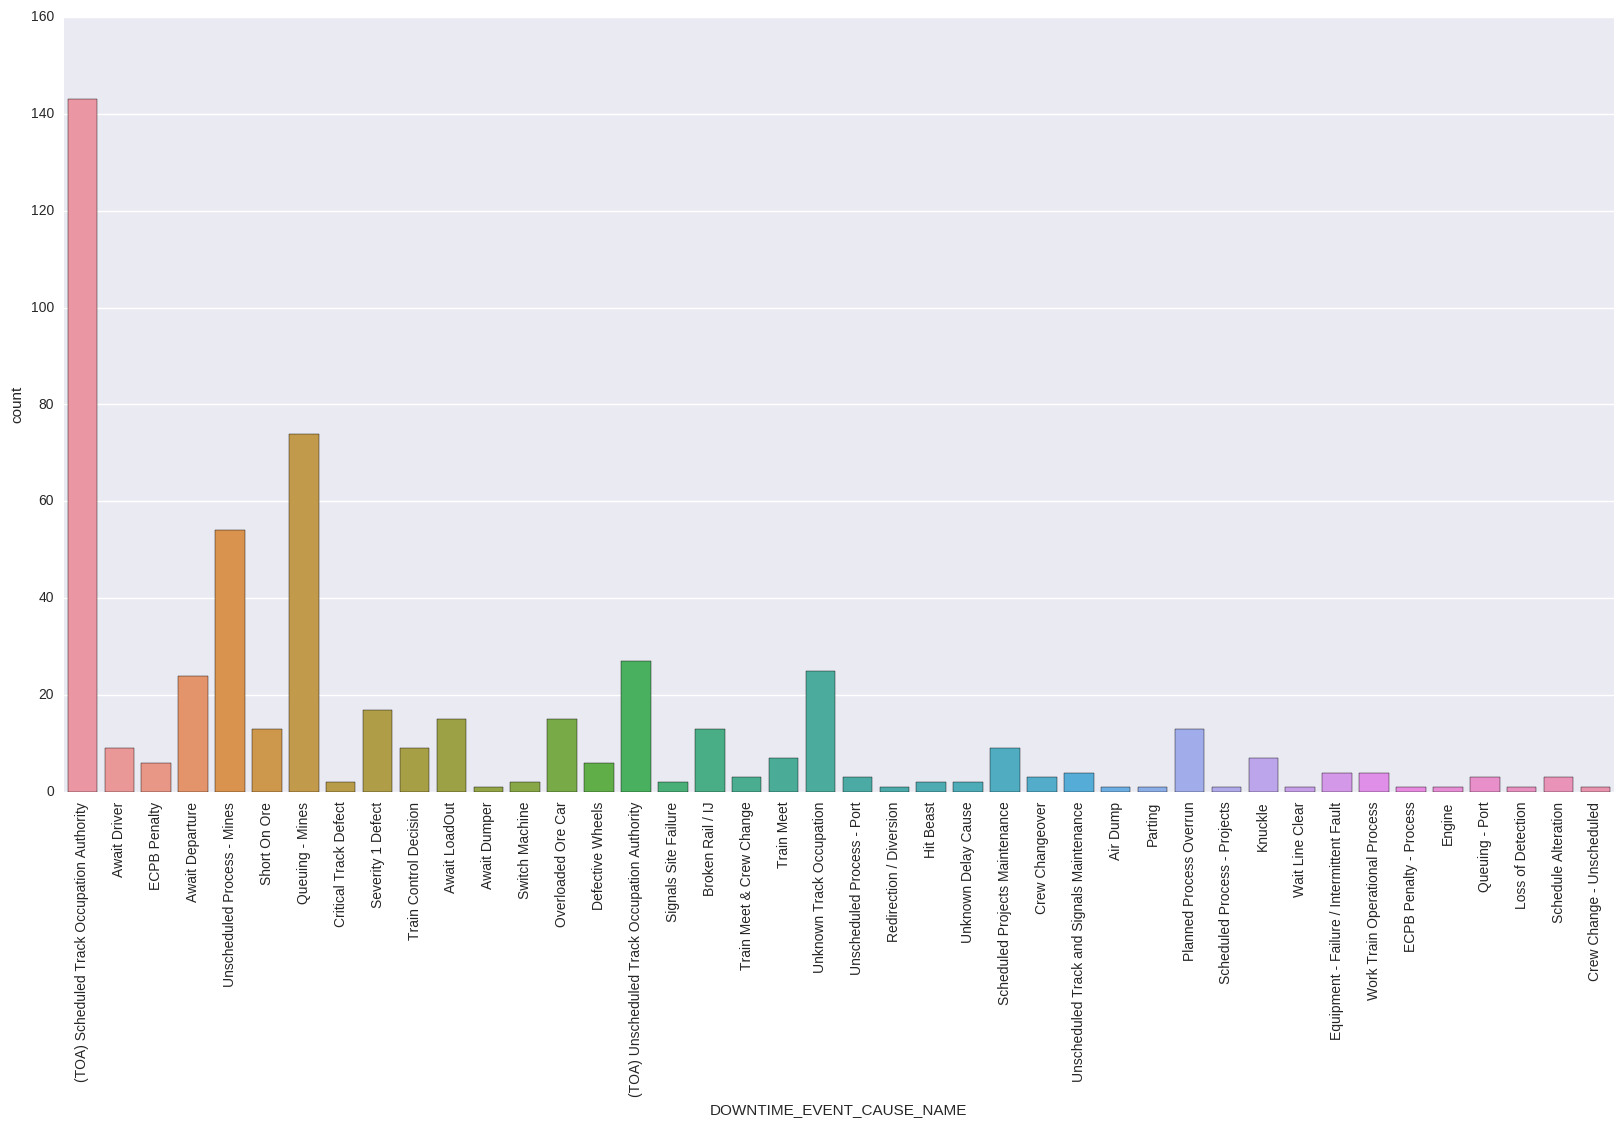

In [24]:
countp(outlier_delays, 'DOWNTIME_EVENT_CAUSE_NAME')

In [25]:
delay_codes = range(len(train_delays['DOWNTIME_EVENT_CAUSE_NAME'].unique()))

delay_causes_first_word = map(lambda line: line.split()[0], train_delays['DOWNTIME_EVENT_CAUSE_NAME'].unique())

delay_mapping = {cause: code for cause, code in zip(delay_causes_first_word, delay_codes)}

bucket_causes(train_delays, 'DOWNTIME_EVENT_CAUSE_NAME')

In [26]:
train_delays

,DOWNTIME_ID,TRIP_LEG_TRAIN_ID,TRAIN_ID,CYCLE_LEG_ID,CYCLE_LEG_NAME,START_CYCLE_POINT_ID,START_CYCLE_POINT_NAME,START_LOCATION_ID,START_LOCATION_CODE,START_LOCATION_NAME,END_CYCLE_POINT_ID,END_CYCLE_POINT_NAME,END_LOCATION_ID,END_LOCATION_CODE,END_LOCATION_NAME,DOWNTIME_CYCLE_LEG_ID,DOWNTIME_CYCLE_LEG_NAME,DOWNTIME_TYPE_ID,DOWNTIME_TYPE_NAME,DOWNTIME_START_DATE,DOWNTIME_END_DATE,DOWNTIME_LOCATION_ID,DOWNTIME_LOCATION_CODE,DOWNTIME_LOCATION_NAME,DOWNTIME_COMMENTS,DOWNTIME_STATUS_ID,DOWNTIME_STATUS_NAME,DOWNTIME_STATUS_DATE,LEG_RUNTIME_HISTORY_ID,VARIANCE_MINUTES,MANUAL_DOWNTIME_FLAG,INITIAL_DOWNTIME_FLAG,DOWNTIME_CREATED_DATE,DOWNTIME_EVENT_ID,DOWNTIME_EVENT_ID.1,DOWNTIME_EVENT_DATE,DOWNTIME_EVENT_CAUSE_ID,DOWNTIME_EVENT_CAUSE_NAME,DOWNTIME_EVENT_CLASS_ID,DOWNTIME_EVENT_CLASS_CODE,DOWNTIME_EVENT_CLASS_NAME,DOWNTIME_EVENT_PAR_CLASS_ID,DOWNTIME_EVENT_PAR_CLASS_NAME,DOWNTIME_DEPARTMENT_ID,DOWNTIME_DEPARTMENT_CODE,DOWNTIME_DEPARTMENT_NAME,DOWNTIME_EVENT_LOCATION_ID,DOWNTIME_EVENT_LOC_TYPE_ID,DOWNTIME_EVENT_LOC_TYPE_NAME,DOWNTIME_EVENT_LOCATION_CODE,DOWNTIME_EVENT_LOCATION_NAME,DOWNTIME_EVENT_DESCRIPTION,LENGTH_OF_DELAY,DOWNTIME_START_DAY,DELAY_CAUSES_BUCKETED
0,80614,10430661,44401060,1390,Tabba Siding,94,Tabba South (to port),1000186,CA03:TAS:P11A,Tabba South 11A Pts,92,Tabba North (to port),1000181,CA03:TAN:P11A,Tabba North 11A Pts,1390,Tabba Siding,1,Stoppage,2016-04-15 07:32:00,2016-04-15 07:56:00,21006,TABBA,TABBA SIDING,NaN,2,Completed,15/APR/2016 08:46:30,156,NaN,N,N,15/APR/2016 07:57:51,66247,66247,15/APR/2016 07:09:00,203,(TOA) Scheduled Track Occupation Authority,1,SPD,Scheduled Process Downtime,1,Scheduled,4,TS,Track and Signals,21003,12,TRACK SECTION,MOOKA - WALLA,MOOKA - WALLA,Scheduled LPA on the ET from Bing South - 67,24,15,22
1,80955,10439889,44439060,1423,Gillam - Tabba,34,Gillam North (to port),1000198,CA03:GMN:P11A,Gillam North 11A Pts,94,Tabba South (to port),1000187,CA03:TAS:P11B,Tabba South 11B Pts,1423,Gillam - Tabba,1,Stoppage,2016-04-17 14:27:00,2016-04-17 18:01:00,21007,TABBA - GILLAM,TABBA - GILLAM,NaN,2,Completed,17/APR/2016 18:06:26,155,NaN,N,N,17/APR/2016 18:03:51,66458,66458,17/APR/2016 10:33:00,203,(TOA) Scheduled Track Occupation Authority,1,SPD,Scheduled Process Downtime,1,Scheduled,4,TS,Track and Signals,21006,12,TRACK SECTION,TABBA,TABBA SIDING,TOA 67KM-TABBA,214,17,22
2,81016,10441968,44465263,1438,Spring - Garden,89,Spring South (to mine),1000318,CA05:SGS:P11A,Spring South 11A Pts,25,Garden North (to mine),1000327,CA06:GNN:P11B,Garden North 11B Pts,1438,Spring - Garden,1,Stoppage,2016-04-18 01:39:00,2016-04-18 02:51:00,21019,SPRING - GARDEN,SPRING - GARDEN,NaN,2,Completed,18/APR/2016 03:08:11,64,NaN,N,N,18/APR/2016 02:52:54,66509,66509,17/APR/2016 19:30:00,37,ECPB Penalty,4,UED,Unscheduled Equipment Downtime,2,Unscheduled,2,LOCO,Locomotives,1000414,12,TRACK SECTION,CHICHESTER - COWRA,CHICHESTER - COWRA,ECPB penalty train walk require C245.5 ECPB p...,72,18,78
3,81042,10443391,44463240,1663,JBJ South - JBJ North,183,JBJ South (to port),1000717,CA11:JJSC:P57,Jimblebar Jtn 57 Pts,50,JBJ North (to port),1000388,CA11:JJN:P51,Jimblebar Jtn 51 Pts,1663,JBJ South - JBJ North,1,Stoppage,2016-04-18 08:42:00,2016-04-18 09:35:00,21109,JIMBLEBAR JUNCTION,JIMBLEBAR JUNCTION,NaN,2,Completed,18/APR/2016 11:57:49,254,NaN,N,Y,18/APR/2016 09:36:51,66570,66570,18/APR/2016 11:56:00,92,Train Meet,1,SPD,Scheduled Process Downtime,1,Scheduled,3,ROP,Railroad Operations,21109,12,TRACK SECTION,JIMBLEBAR JUNCTION,JIMBLEBAR JUNCTION,Meet Train M06444,53,18,81
4,81073,10444072,44467086,10128,OB18 North - Jimblebar Hub,10108,OB18 North (to mine),1000727,CA16:OB18N:P61A,OB 18 Pts 61A,10112,Jimblebar Hub (to mine),1000739,CA16:JHN:P66,Jimblebar Hub North 66 Pts,10128,OB18 North - Jimblebar Hub,1,Stoppage,2016-04-18 13:27:00,2016-04-18 15:56:00,1000828,OB18 NORTH - JIMBLEBAR HUB,OB18 NORTH - JIMBLEBAR HUB,NaN,2,Completed,18/APR/2016 17:27:22,140,NaN,N,Y,18/APR/2016 15:57:51,66583,66583,18/APR/2016 17:26:00,28,Queuing - Mines,1

In [27]:
scheduled_delay = train_delays[train_delays['DOWNTIME_EVENT_PAR_CLASS_NAME'] == 'Scheduled']
unscheduled_delay = train_delays[train_delays['DOWNTIME_EVENT_PAR_CLASS_NAME'] == 'Unscheduled']

In [28]:
list(scheduled_delay['DOWNTIME_EVENT_CAUSE_NAME'].unique())

['(TOA) Scheduled Track Occupation Authority',
 'Train Meet',
 'Queuing - Mines',
 'Train Meet & Crew Change',
 'Crew Changeover',
 'Await Departure',
 'Queuing - Port',
 'Work Train Operational Process',
 'Planned Equipment Overrun',
 'Planned Process Overrun',
 'Personal Needs Break',
 'Scheduled Projects Maintenance',
 'Scheduled Process - Projects',
 'Blasting',
 'LPA (Local Possession Authority) ']

In [29]:
list(unscheduled_delay['DOWNTIME_EVENT_CAUSE_NAME'].unique())

['ECPB Penalty',
 'Await Driver',
 'Unscheduled Process - Mines',
 'Speed / Handling',
 'ATP Penalty',
 'Controller Communication',
 'Air Leak / Brake System',
 'Train Control Decision',
 'ATP Penalty - Process',
 'Unknown Track Occupation',
 'Switch Machine',
 'Short On Ore',
 'Critical Track Defect',
 'Severity 1 Defect',
 'Engine',
 '(TOA) Unscheduled Track Occupation Authority',
 'Brake System',
 'Overloaded Ore Car',
 'Await Dumper',
 'Await LoadOut',
 'Wait Line Clear',
 'Operator Error',
 'Unplanned Overrun',
 'Personal Needs Break / Overrun',
 'Onboard Systems',
 'Crew Change - Unscheduled',
 'ECPB Set up - Process',
 'Signals Site Failure',
 'Loss of Detection',
 'EOTM Lost / No COMMS',
 'Unknown Delay Cause',
 'Air Dump',
 'Defective Wheels',
 'Telemetry / Loss of Comms',
 'Hit Beast',
 'Equipment - Failure / Intermittent Fault',
 'Unscheduled Track and Signals Maintenance',
 'Redirection / Diversion',
 'Unscheduled Process - Projects',
 'Broken Rail / IJ',
 'Handbrakes Not R

### TYPE OF DELAY

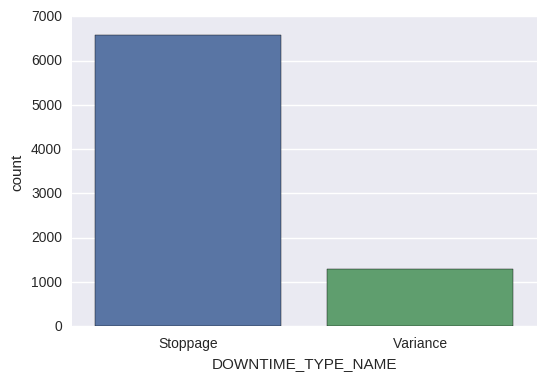

In [30]:
sns.countplot(train_delays['DOWNTIME_TYPE_NAME'])

In [31]:
delay_info(train_delays, 'DOWNTIME_TYPE_NAME', 'Stoppage')

Mean delay length for Stoppage: 75.4410467062
Median delay length for Stoppage: 50.0
Max delay length for Stoppage: 1418


In [32]:
delay_info(train_delays, 'DOWNTIME_TYPE_NAME', 'Variance')

Mean delay length for Variance: 91.4432432432
Median delay length for Variance: 77.0
Max delay length for Variance: 1180


### DOWNTIME EVENT CAUSE NAME

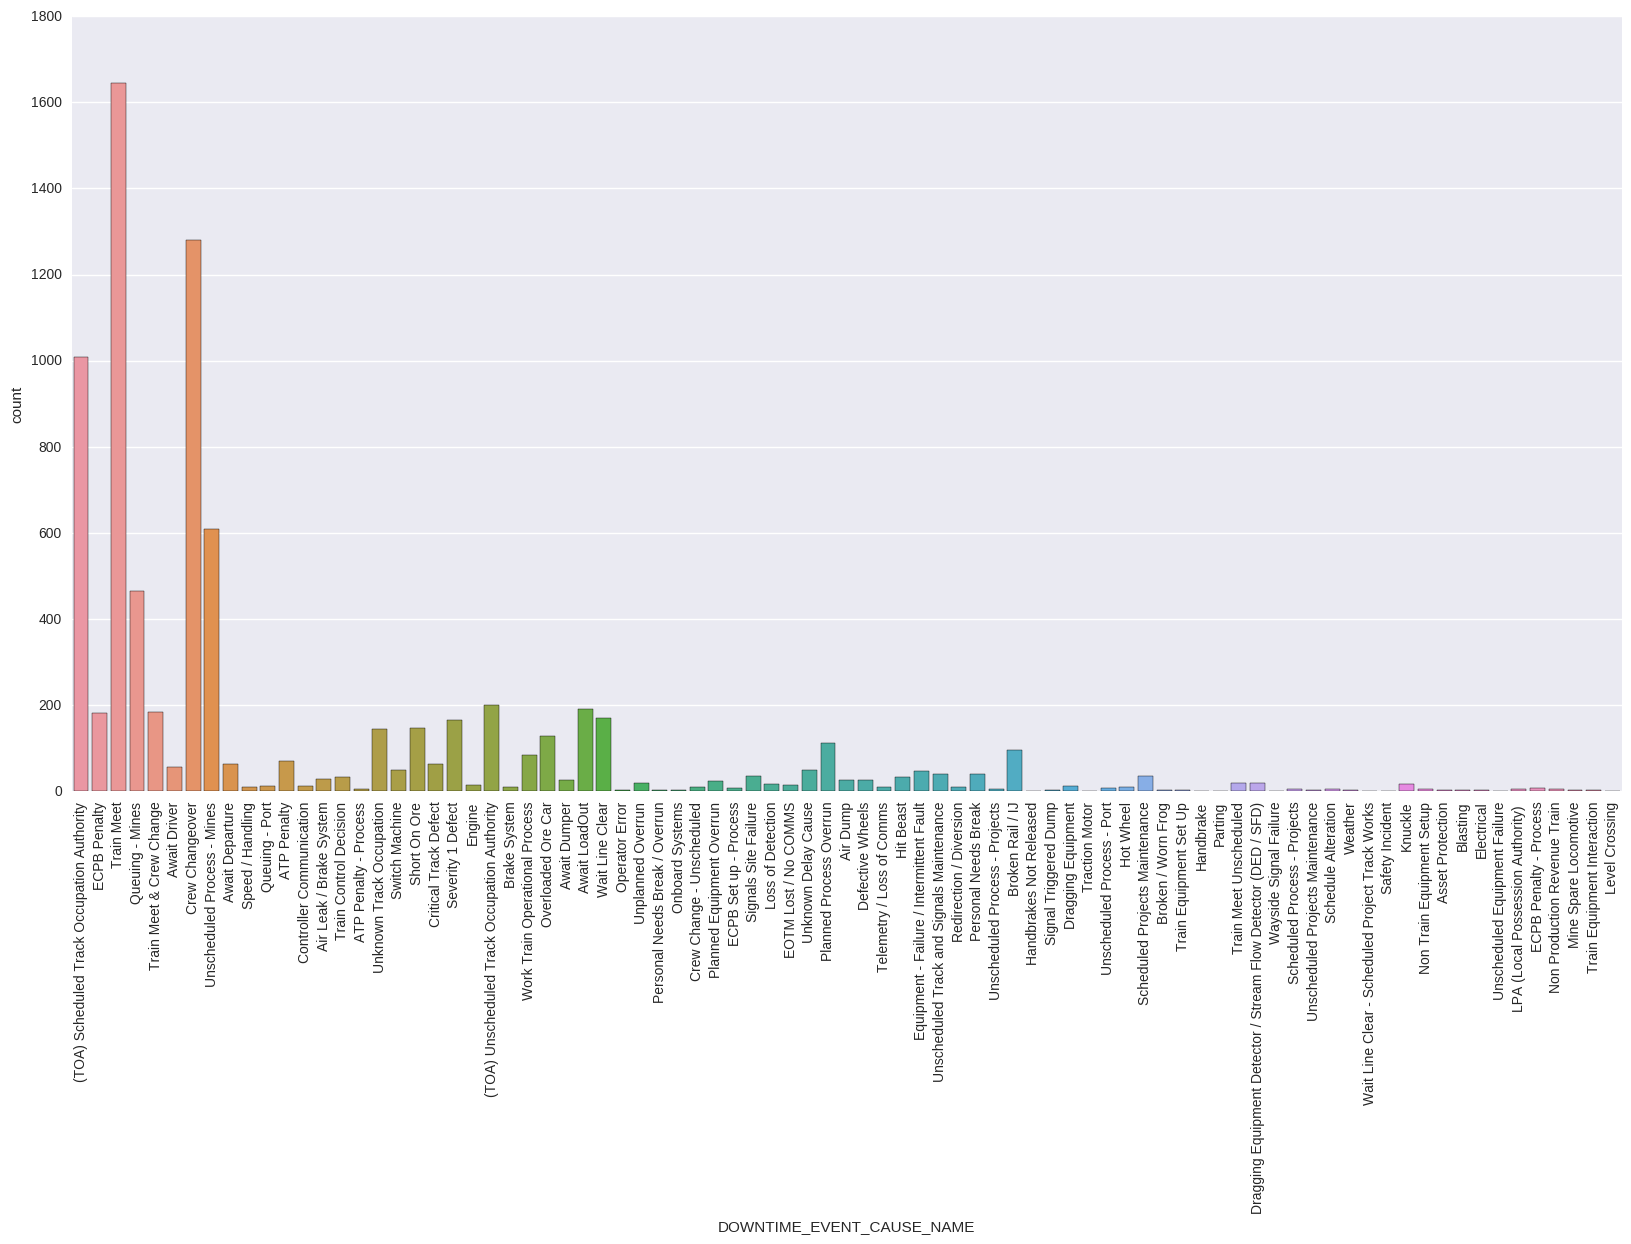

In [33]:
countp(train_delays, 'DOWNTIME_EVENT_CAUSE_NAME')

In [34]:
delay_info(train_delays, 'DOWNTIME_EVENT_CAUSE_NAME', 'Train Meet')

Mean delay length for Train Meet: 45.7135036496
Median delay length for Train Meet: 37.0
Max delay length for Train Meet: 795


In [35]:
delay_info(train_delays, 'DOWNTIME_EVENT_CAUSE_NAME', 'Crew Changeover')

Mean delay length for Crew Changeover: 46.45546875
Median delay length for Crew Changeover: 39.0
Max delay length for Crew Changeover: 525


### DOWNTIME EVENT LOCATION TYPE NAME

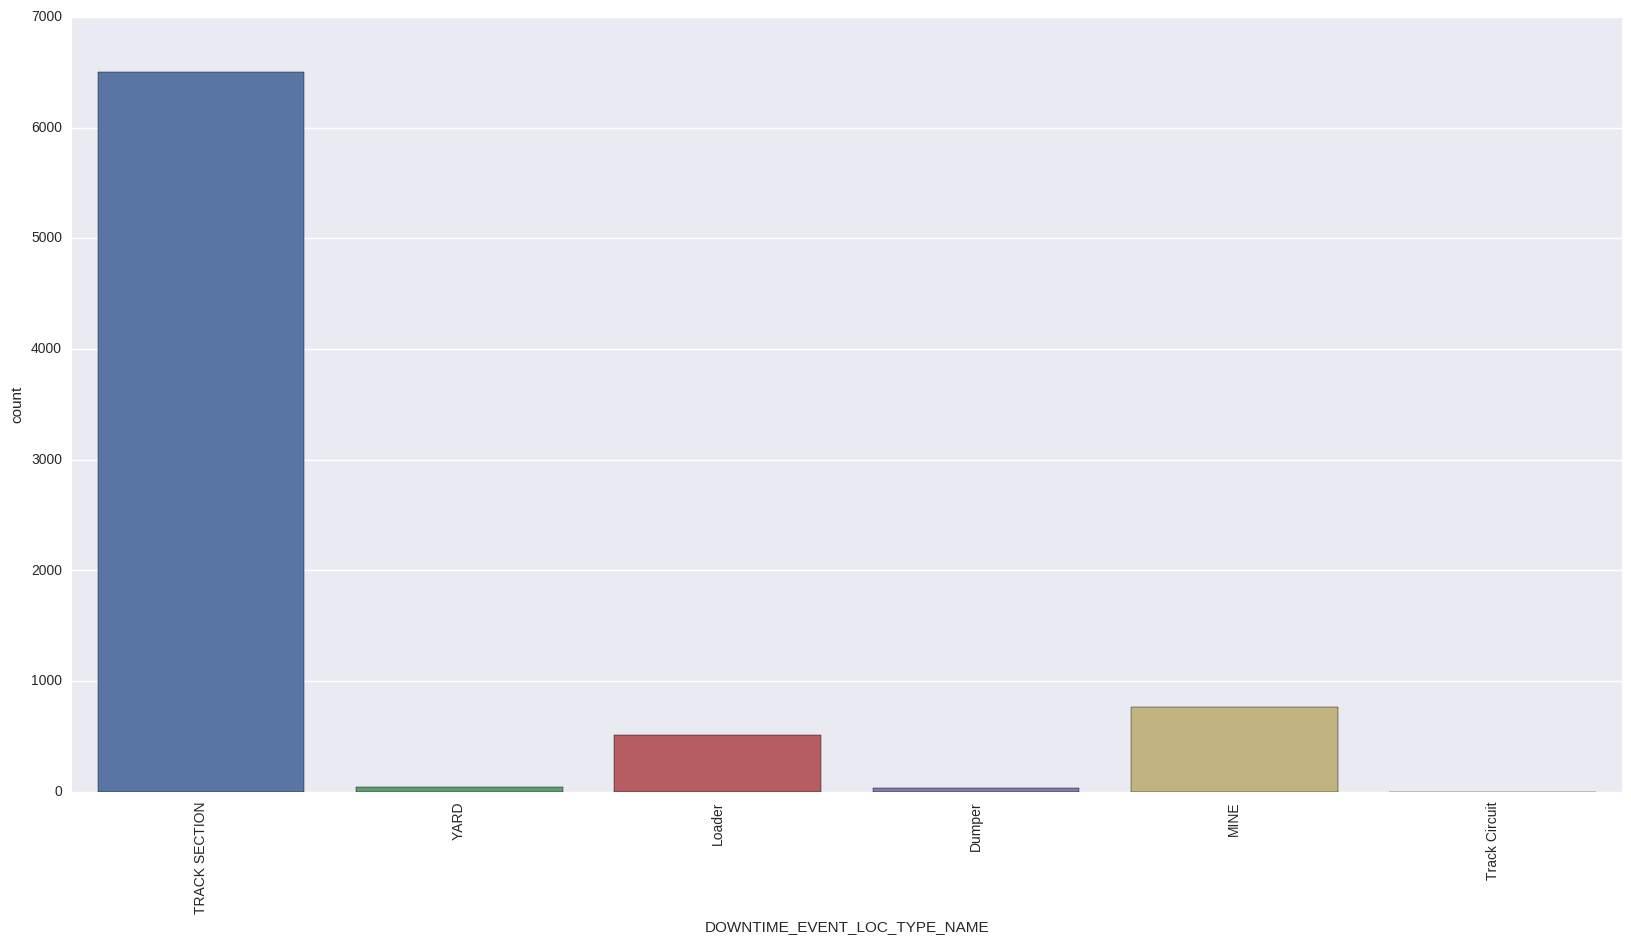

In [36]:
countp(train_delays, 'DOWNTIME_EVENT_LOC_TYPE_NAME')

In [37]:
delay_info(train_delays, 'DOWNTIME_EVENT_LOC_TYPE_NAME', 'TRACK SECTION')

Mean delay length for TRACK SECTION: 74.9078177901
Median delay length for TRACK SECTION: 50.0
Max delay length for TRACK SECTION: 1418


In [38]:
delay_info(train_delays, 'DOWNTIME_EVENT_LOC_TYPE_NAME', 'Loader')

Mean delay length for Loader: 99.507751938
Median delay length for Loader: 81.0
Max delay length for Loader: 1180


# BUILD MODEL

In [39]:
train_delays.head()

,DOWNTIME_ID,TRIP_LEG_TRAIN_ID,TRAIN_ID,CYCLE_LEG_ID,CYCLE_LEG_NAME,START_CYCLE_POINT_ID,START_CYCLE_POINT_NAME,START_LOCATION_ID,START_LOCATION_CODE,START_LOCATION_NAME,END_CYCLE_POINT_ID,END_CYCLE_POINT_NAME,END_LOCATION_ID,END_LOCATION_CODE,END_LOCATION_NAME,DOWNTIME_CYCLE_LEG_ID,DOWNTIME_CYCLE_LEG_NAME,DOWNTIME_TYPE_ID,DOWNTIME_TYPE_NAME,DOWNTIME_START_DATE,DOWNTIME_END_DATE,DOWNTIME_LOCATION_ID,DOWNTIME_LOCATION_CODE,DOWNTIME_LOCATION_NAME,DOWNTIME_COMMENTS,DOWNTIME_STATUS_ID,DOWNTIME_STATUS_NAME,DOWNTIME_STATUS_DATE,LEG_RUNTIME_HISTORY_ID,VARIANCE_MINUTES,MANUAL_DOWNTIME_FLAG,INITIAL_DOWNTIME_FLAG,DOWNTIME_CREATED_DATE,DOWNTIME_EVENT_ID,DOWNTIME_EVENT_ID.1,DOWNTIME_EVENT_DATE,DOWNTIME_EVENT_CAUSE_ID,DOWNTIME_EVENT_CAUSE_NAME,DOWNTIME_EVENT_CLASS_ID,DOWNTIME_EVENT_CLASS_CODE,DOWNTIME_EVENT_CLASS_NAME,DOWNTIME_EVENT_PAR_CLASS_ID,DOWNTIME_EVENT_PAR_CLASS_NAME,DOWNTIME_DEPARTMENT_ID,DOWNTIME_DEPARTMENT_CODE,DOWNTIME_DEPARTMENT_NAME,DOWNTIME_EVENT_LOCATION_ID,DOWNTIME_EVENT_LOC_TYPE_ID,DOWNTIME_EVENT_LOC_TYPE_NAME,DOWNTIME_EVENT_LOCATION_CODE,DOWNTIME_EVENT_LOCATION_NAME,DOWNTIME_EVENT_DESCRIPTION,LENGTH_OF_DELAY,DOWNTIME_START_DAY,DELAY_CAUSES_BUCKETED
0,80614,10430661,44401060,1390,Tabba Siding,94,Tabba South (to port),1000186,CA03:TAS:P11A,Tabba South 11A Pts,92,Tabba North (to port),1000181,CA03:TAN:P11A,Tabba North 11A Pts,1390,Tabba Siding,1,Stoppage,2016-04-15 07:32:00,2016-04-15 07:56:00,21006,TABBA,TABBA SIDING,NaN,2,Completed,15/APR/2016 08:46:30,156,NaN,N,N,15/APR/2016 07:57:51,66247,66247,15/APR/2016 07:09:00,203,(TOA) Scheduled Track Occupation Authority,1,SPD,Scheduled Process Downtime,1,Scheduled,4,TS,Track and Signals,21003,12,TRACK SECTION,MOOKA - WALLA,MOOKA - WALLA,Scheduled LPA on the ET from Bing South - 67,24,15,22
1,80955,10439889,44439060,1423,Gillam - Tabba,34,Gillam North (to port),1000198,CA03:GMN:P11A,Gillam North 11A Pts,94,Tabba South (to port),1000187,CA03:TAS:P11B,Tabba South 11B Pts,1423,Gillam - Tabba,1,Stoppage,2016-04-17 14:27:00,2016-04-17 18:01:00,21007,TABBA - GILLAM,TABBA - GILLAM,NaN,2,Completed,17/APR/2016 18:06:26,155,NaN,N,N,17/APR/2016 18:03:51,66458,66458,17/APR/2016 10:33:00,203,(TOA) Scheduled Track Occupation Authority,1,SPD,Scheduled Process Downtime,1,Scheduled,4,TS,Track and Signals,21006,12,TRACK SECTION,TABBA,TABBA SIDING,TOA 67KM-TABBA,214,17,22
2,81016,10441968,44465263,1438,Spring - Garden,89,Spring South (to mine),1000318,CA05:SGS:P11A,Spring South 11A Pts,25,Garden North (to mine),1000327,CA06:GNN:P11B,Garden North 11B Pts,1438,Spring - Garden,1,Stoppage,2016-04-18 01:39:00,2016-04-18 02:51:00,21019,SPRING - GARDEN,SPRING - GARDEN,NaN,2,Completed,18/APR/2016 03:08:11,64,NaN,N,N,18/APR/2016 02:52:54,66509,66509,17/APR/2016 19:30:00,37,ECPB Penalty,4,UED,Unscheduled Equipment Downtime,2,Unscheduled,2,LOCO,Locomotives,1000414,12,TRACK SECTION,CHICHESTER - COWRA,CHICHESTER - COWRA,ECPB penalty train walk require C245.5 ECPB p...,72,18,78
3,81042,10443391,44463240,1663,JBJ South - JBJ North,183,JBJ South (to port),1000717,CA11:JJSC:P57,Jimblebar Jtn 57 Pts,50,JBJ North (to port),1000388,CA11:JJN:P51,Jimblebar Jtn 51 Pts,1663,JBJ South - JBJ North,1,Stoppage,2016-04-18 08:42:00,2016-04-18 09:35:00,21109,JIMBLEBAR JUNCTION,JIMBLEBAR JUNCTION,NaN,2,Completed,18/APR/2016 11:57:49,254,NaN,N,Y,18/APR/2016 09:36:51,66570,66570,18/APR/2016 11:56:00,92,Train Meet,1,SPD,Scheduled Process Downtime,1,Scheduled,3,ROP,Railroad Operations,21109,12,TRACK SECTION,JIMBLEBAR JUNCTION,JIMBLEBAR JUNCTION,Meet Train M06444,53,18,81
4,81073,10444072,44467086,10128,OB18 North - Jimblebar Hub,10108,OB18 North (to mine),1000727,CA16:OB18N:P61A,OB 18 Pts 61A,10112,Jimblebar Hub (to mine),1000739,CA16:JHN:P66,Jimblebar Hub North 66 Pts,10128,OB18 North - Jimblebar Hub,1,Stoppage,2016-04-18 13:27:00,2016-04-18 15:56:00,1000828,OB18 NORTH - JIMBLEBAR HUB,OB18 NORTH - JIMBLEBAR HUB,NaN,2,Completed,18/APR/2016 17:27:22,140,NaN,N,Y,18/APR/2016 15:57:51,66583,66583,18/APR/2016 17:26:00,28,Queuing - Mines,1

In [40]:
X = train_delays[['START_LOCATION_ID', 'END_LOCATION_ID',
                  'DOWNTIME_EVENT_LOC_TYPE_ID', 'DOWNTIME_EVENT_LOCATION_ID',
                  'LENGTH_OF_DELAY', 'DOWNTIME_START_DAY']]
y = train_delays['DOWNTIME_EVENT_PAR_CLASS_NAME'].apply(lambda x: 1 if x == 'Scheduled' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [41]:
with open('unseen_predict.pk', 'w') as f:
    pk.dump(X_test, f)

### XGBOOST

In [42]:
xgb_params = {'n_estimators': [300],
              'learning_rate': [.1],
              'reg_alpha': [1, 2, 5, 10],
              'reg_lambda': [1, 2, .5, .10]}
xgb_gs = GridSearchCV(XGBClassifier(), param_grid=xgb_params, cv=5, scoring='roc_auc').fit(X_train, y_train)
xgb_params = xgb_gs.best_params_

n_estimators = 300
learning_rate = .1
alpha = 2
lambda = 1

In [43]:
xgb = XGBClassifier(n_estimators=300,
                    learning_rate=.1,
                    reg_alpha=2,
                    reg_lambda=1).fit(X_train, y_train)

In [44]:
# with open('xgb_predict.pk', 'w') as f:
#     pk.dump(xgb, f)

In [45]:
xgb.score(X_test, y_test)

0.74650571791613718

In [46]:
shuffle = ShuffleSplit(len(X_train), n_iter=20, test_size=0.2)
np.mean(cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=shuffle))

0.81013673333044989

In [47]:
xgb_predict_prob = xgb.predict_proba(X_test)[:, 1]

In [48]:
roc_score = roc_auc_score(y_test, xgb_predict_prob)

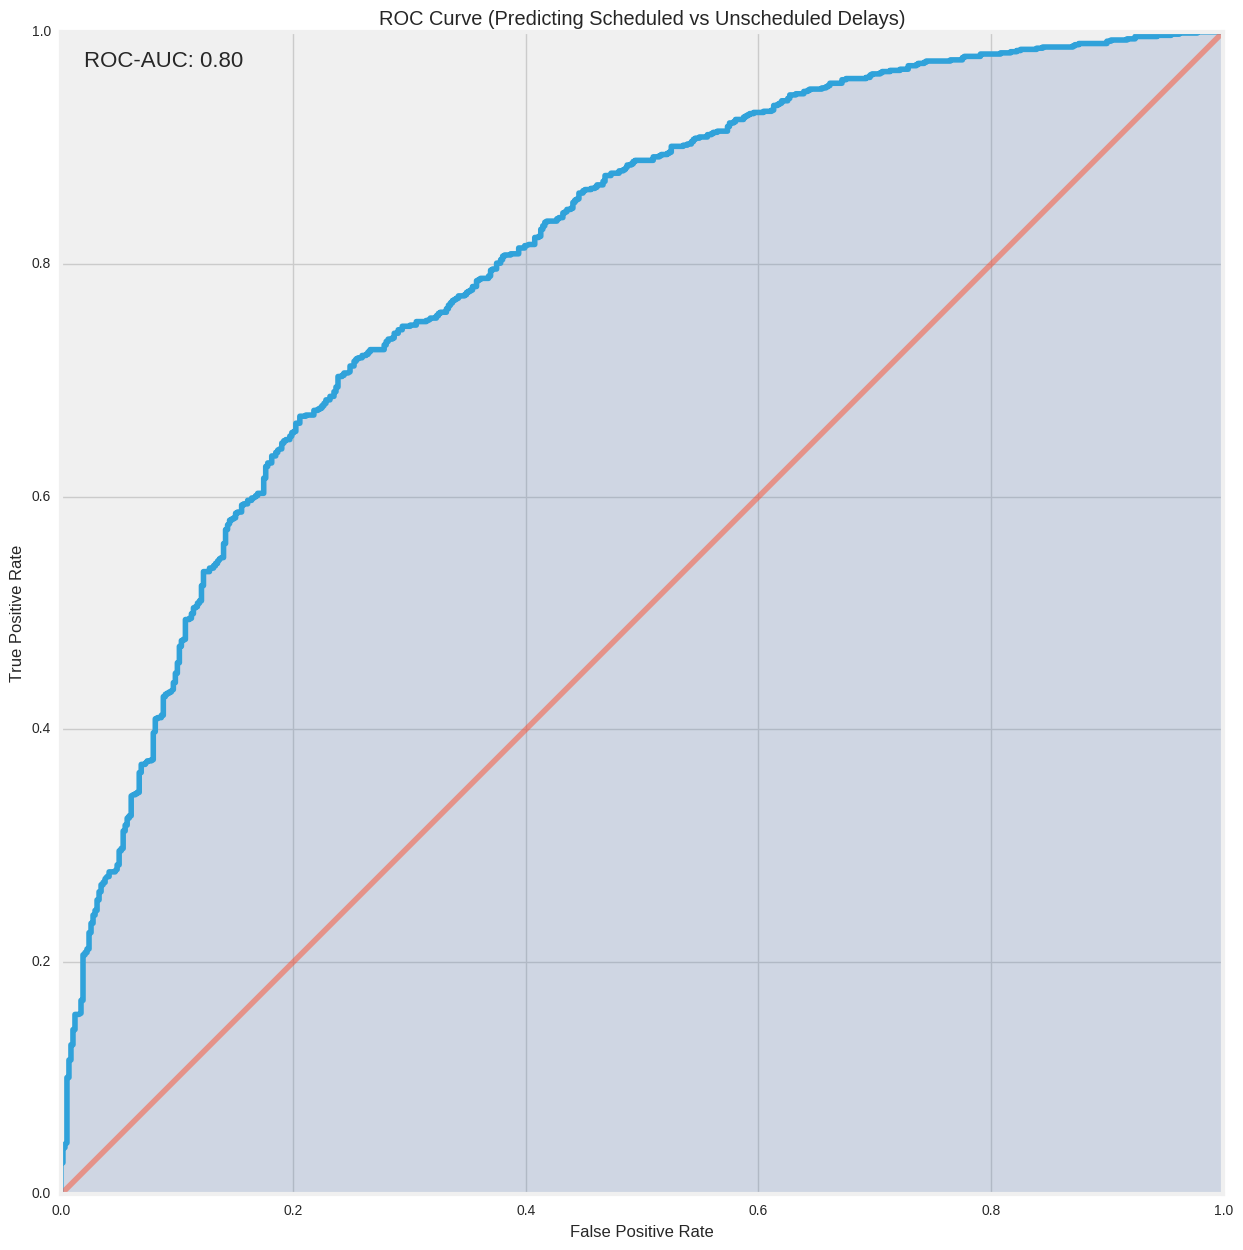

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_predict_prob)
plt.figure(figsize=(15, 15))
with plt.style.context('fivethirtyeight'):
    plt.plot(fpr, tpr)
    plt.plot(np.linspace(0, 1, 5), np.linspace(0, 1, 5), alpha=.5)
    plt.fill_between(fpr, 0, tpr, alpha=.2)
    plt.title('ROC Curve (Predicting Scheduled vs Unscheduled Delays)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.text(.02, .97, 'ROC-AUC: {:.2f}'.format(roc_score), fontsize=16)

### EXPLORE UNSCHEDULED

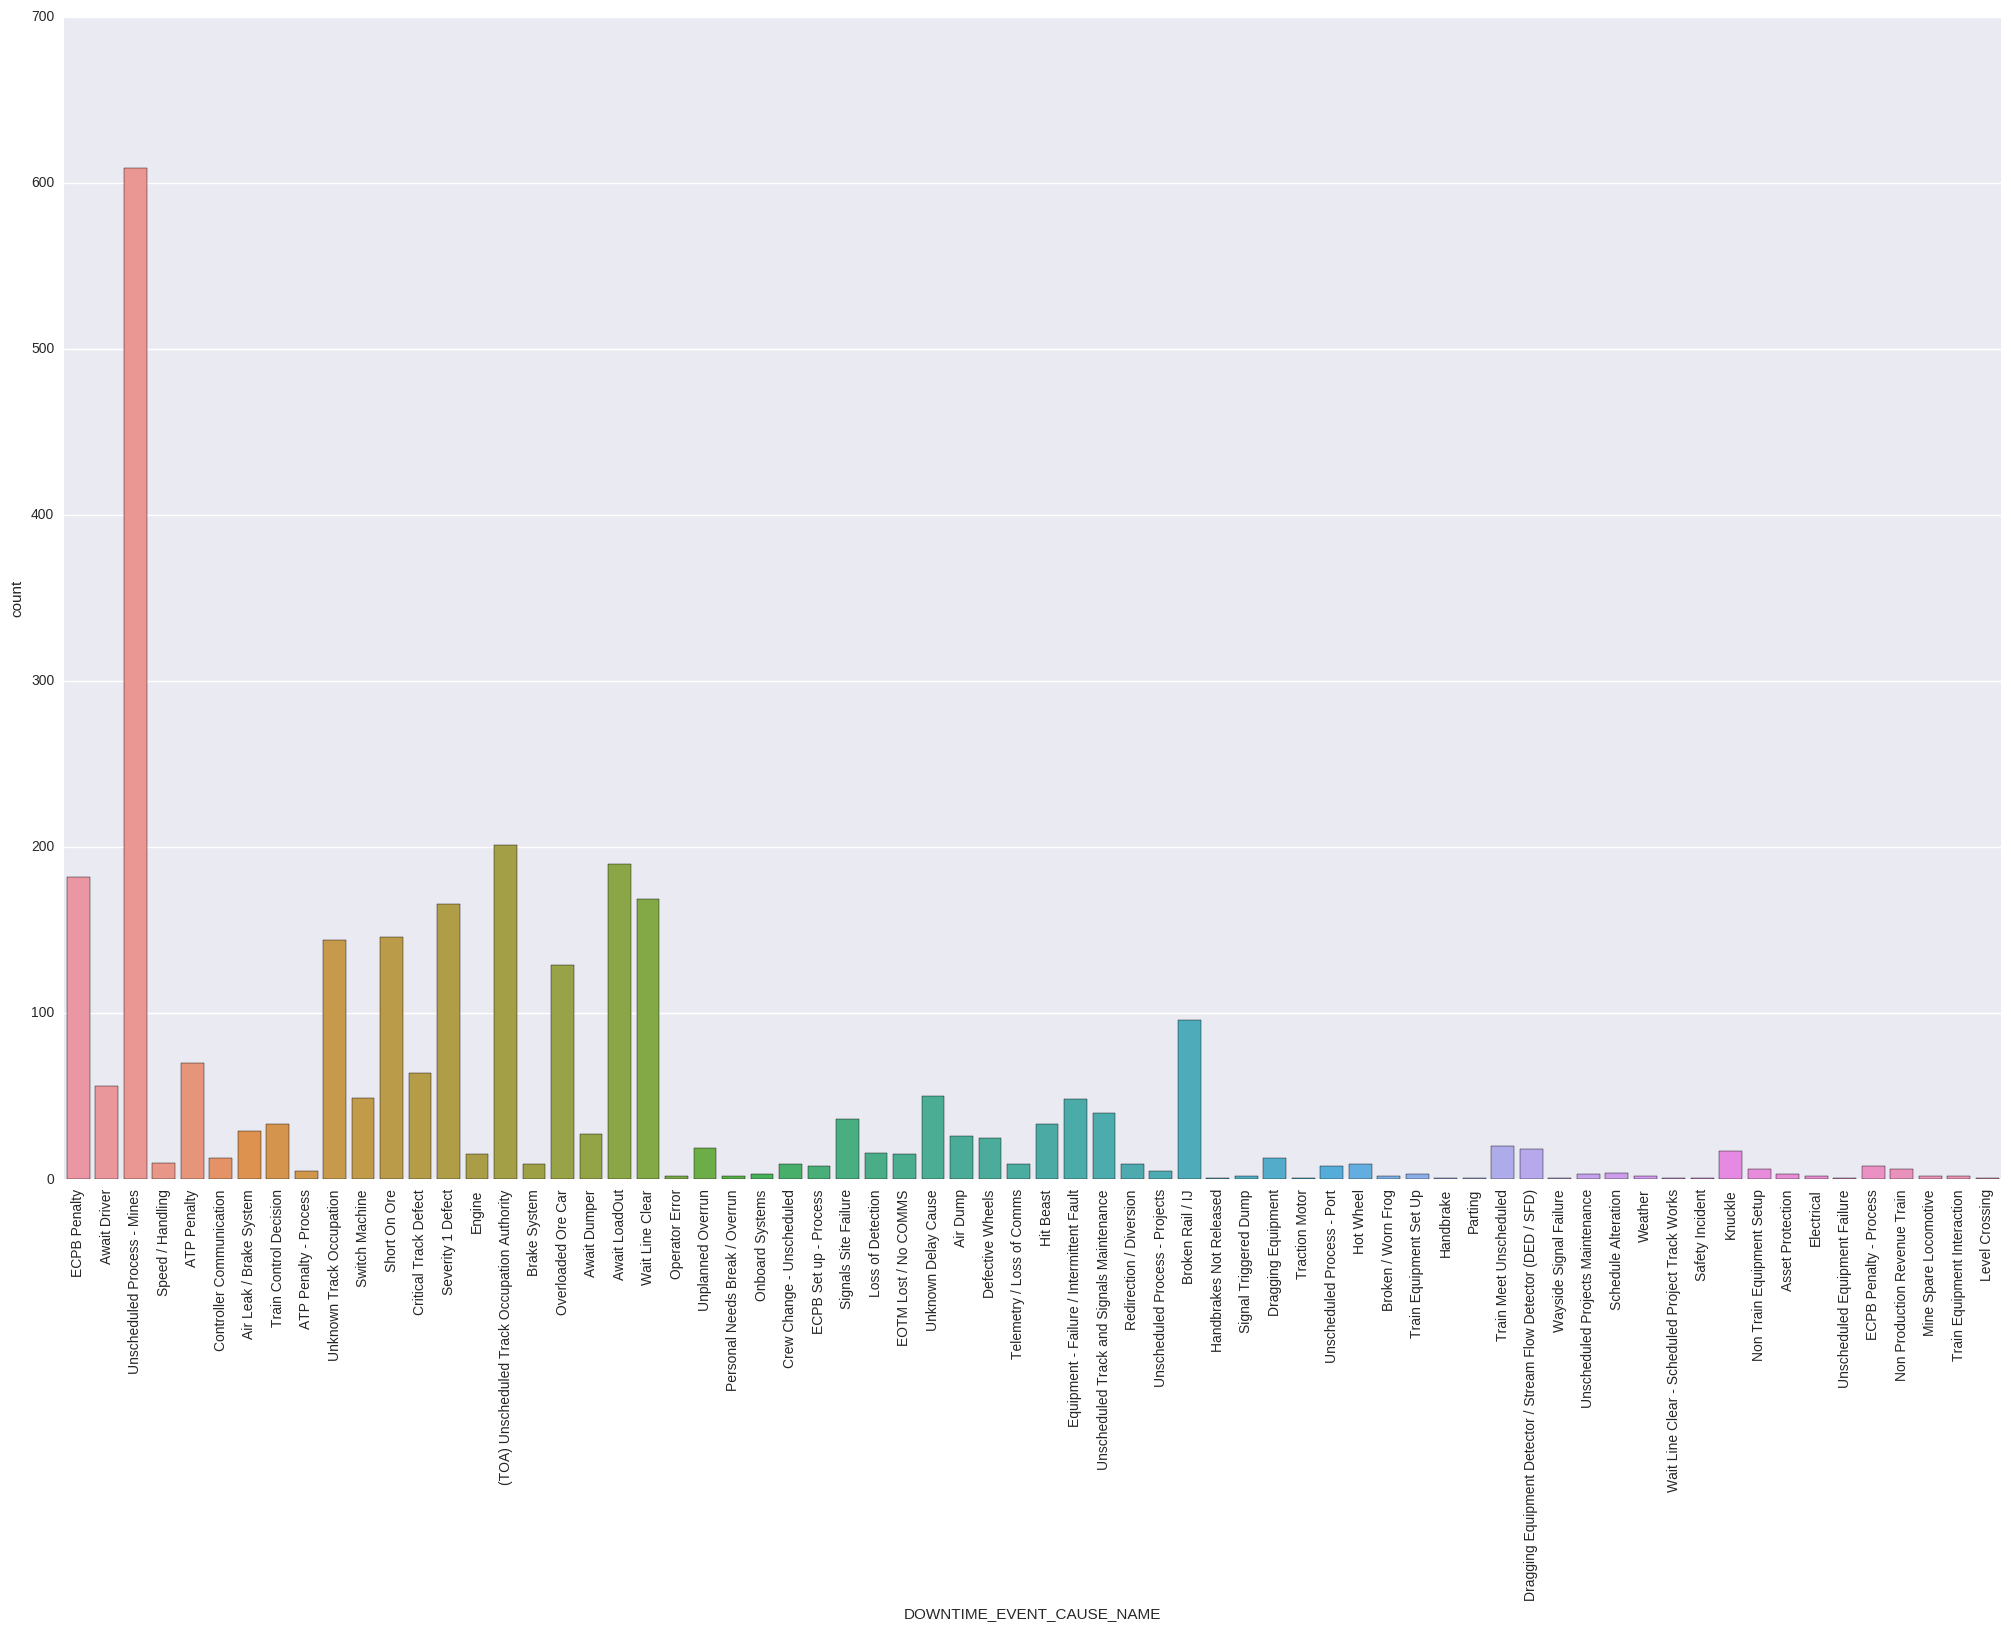

In [50]:
countp(unscheduled_delay, 'DOWNTIME_EVENT_CAUSE_NAME', size=(25, 15))

In [51]:
delay_cause_buckets = {('ATP Penalty', 'ATP Penalty - Process', 'ECPB Penalty - Process', 'Asset Protection',
                        'Unknown Track Occupation', 'ECPB Penalty', 'Signal Triggered Dump'): 'Asset Protection System',
                       ('Unscheduled Process', 'Overloaded Ore Car', 'Await Dumper', 'Await LoadOut', 'Non Train Equipment Setup', 
                        'Non Production Revenue Train', 'Await Driver', 'Unscheduled Process - Mines', 'Short On Ore',
                        'Level Crossing', 'Wait Line Clear - Scheduled Project Track Works', 'Unscheduled Process - Port',
                        'Redirection / Diversion'): 'Non Train',
                       ('Operator Error', 'Unplanned Overrun', 'Personal Needs Break / Overrun', 'Crew Change - Unscheduled',
                        'ECPB Set up - Process', 'Handbrakes Not Released', 'Speed / Handling'): 'OE',
                       ('Weather', 'Hit Beast', 'Unknown Delay Cause'): 'Misc'}

In [52]:
def find_bucket(event):
    for k, v in delay_cause_buckets.iteritems():
        if event in k:
            return delay_cause_buckets[k]
    return 'Maintenance'

In [53]:
unscheduled_delay['CAUSE_BUCKETS'] = unscheduled_delay['DOWNTIME_EVENT_CAUSE_NAME'].apply(lambda x: find_bucket(x))

/home/peterwen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [54]:
X_uns = unscheduled_delay[['START_LOCATION_ID', 'END_LOCATION_ID',
                           'DOWNTIME_EVENT_LOC_TYPE_ID', 'DOWNTIME_EVENT_LOCATION_ID',
                           'LENGTH_OF_DELAY']]
y_uns = unscheduled_delay['CAUSE_BUCKETS']

In [55]:
X_uns_train, X_uns_test, y_uns_train, y_uns_test = train_test_split(X_uns, y_uns, test_size=.2)

In [56]:
with open('unseen_predict_unsched_causes.pk', 'w') as f:
    pk.dump(X_uns_test, f)

In [57]:
xgb_uns_params = {'n_estimators': [300],
                  'learning_rate': [.1],
                  'reg_alpha': [1, 2, 5, 10],
                  'reg_lambda': [1, 2, .5, .10]}
xgb_uns_gs = GridSearchCV(XGBClassifier(), param_grid=xgb_uns_params, cv=5).fit(X_uns_train, y_uns_train)
xgb_uns_params = xgb_uns_gs.best_params_

In [58]:
xgb_uns_params

{'learning_rate': 0.1, 'n_estimators': 300, 'reg_alpha': 2, 'reg_lambda': 2}

In [59]:
xgb_uns = XGBClassifier(n_estimators=300,
                        learning_rate=.1,
                        reg_alpha=5,
                        reg_lambda=2).fit(X_uns_train, y_uns_train)

In [60]:
xgb_uns.classes_

array(['Asset Protection System', 'Maintenance', 'Misc', 'Non Train', 'OE'], dtype=object)

In [61]:
# with open('xgb_predict unsched_causes.pk', 'w') as f:
#     pk.dump(xgb_uns, f)

In [62]:
accuracy = xgb_uns.score(X_uns_test, y_uns_test)
print accuracy

0.742268041237


In [63]:
def top_2_score(est, X, y):
    pp = est.predict_proba(X)
    top_2_index = np.argsort(pp)[:,-2:]
    score = 0
    total = 0
    for y, top_2 in zip(y, est.classes_[top_2_index]):
        if y in top_2:
            score += 1
        total += 1.
    return score / total

In [64]:
top_2_accuracy = top_2_score(xgb_uns, X_uns_test, y_uns_test)
print top_2_accuracy

0.920962199313


### GET TRIPS PER STATION

In [65]:
train_track_sec['START_CYCLE_POINT_NAME'].fillna('MISSING', inplace=True)
train_track_sec['START_CYCLE_POINT_NAME_CLEANED'] = train_track_sec['START_CYCLE_POINT_NAME'].apply(lambda x: re.search(r'(.*)\s\(.*\)', x).group(1) if bool(re.search(r'(.*)\s\(.*\)', x)) else x)

In [66]:
trips_per_start = Counter(train_track_sec['START_CYCLE_POINT_NAME_CLEANED'])

In [67]:
pd.DataFrame(trips_per_start.items(), columns=['START_CYCLE_POINT_NAME', 'NUMBER_OF_TRIPS']).to_csv('trips_per_start.csv')